# Task 1

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<li> Create pandas dataframe from csv file:

In [207]:
country_df = pd.read_csv("archive/GlobalLandTemperaturesByCountry.csv")

<li> Create a new colum in country df which will represent the decade 
<li> Group dataframe entries by country and decade and find the mean of AverageTemperature in each decade
<li> Create a new dataframe called changes_df which will have as columns:
    <ol>
        <li> the country name
        <li> the decade
        <li> AverageTemperature for each decade
        <li> Gradient: Showing the changes from decade to decade    
     </ol>       
<li> Each country has 28 decade, the first one is 1740
<li> The gradient of the first decade would be set to NaN since it doestn't have previous values to be compared

In [214]:
country_df['decade']=(country_df['dt'].apply(lambda x: x[:3])).astype('category')
grouped = country_df.groupby(["Country","decade"])['AverageTemperature'].mean()

changes_df = grouped.to_frame(name = 'avg_temp/decade').reset_index()
changes_df['gradient'] = changes_df['avg_temp/decade'].diff()
changes_df.gradient = changes_df['gradient'].apply(abs)

decades = changes_df.groupby("Country").size()
print(set(decades))

changes_df.loc[(changes_df.decade == '174'),"gradient"]=np.nan

changes_df.head()

{28}


,Country,decade,avg_temp/decade,gradient
0,Afghanistan,174,NaN,NaN
1,Afghanistan,175,NaN,NaN
2,Afghanistan,176,NaN,NaN
3,Afghanistan,177,NaN,NaN
4,Afghanistan,178,NaN,NaN


<li> The average of the gradients for each country will be calculated
<li> The one with the highest average is the one who had the most severe overall temperature change
<li> In this dataset the Country with the most severe changes from decade to decade is <b>Åland

In [215]:
changes_df.groupby("Country")["gradient"].mean().to_frame(name = 'overall_change').reset_index().max()

Country              Åland
overall_change    0.889868
dtype: object

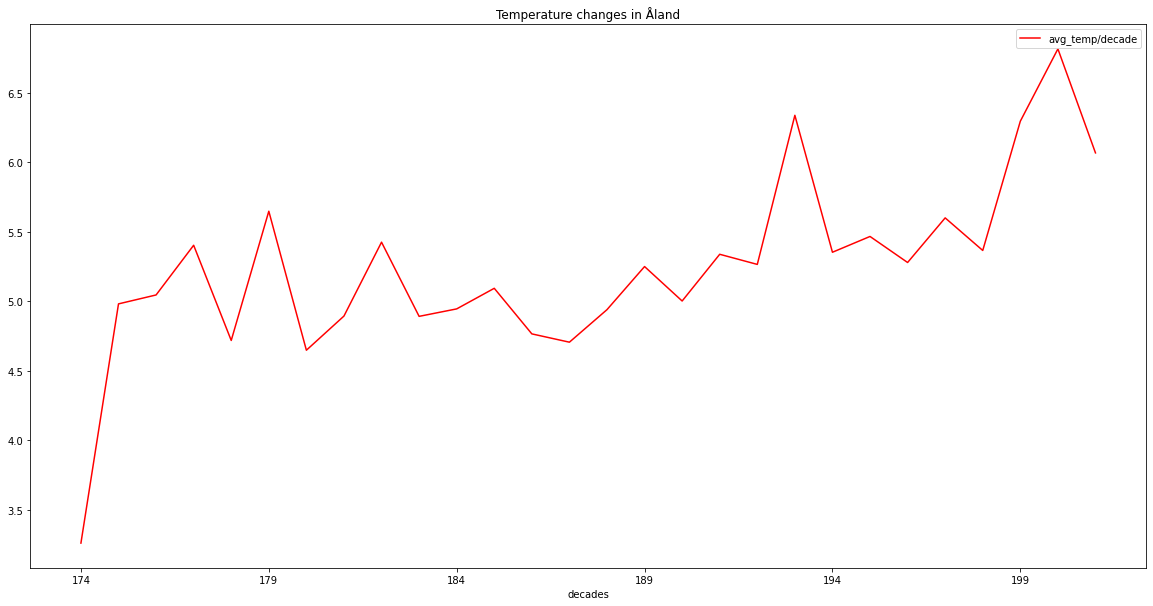

In [217]:
"""
This function is used to plot the changes in Average Temperature for each decade in a given city
It takes as input:
changes_df (pandas df): A dataframe of countries with average temperature changes in decades 
country (String):       Country name
"""

def plot_changes_in_decades(df,country):
        df = df[df["Country"] == country]
        ax = df.plot(kind='line',x='decade',y='avg_temp/decade',color='red',figsize=(20,10),
                     title = "Temperature changes in "+country)
        ax.set_xlabel("decades")
#         ax.set_ylabel("Changes in temperature f")
        plt.show()
    
plot_changes_in_decades(changes_df,"Åland")

# Task 2: Highest Variability in AverageTemperature

<li> Create city pandas dataframe from csv file:
    

In [136]:
city_df = pd.read_csv("archive/GlobalLandTemperaturesByCity.csv")

<li> The function below returns the N cities with the highest variability in a specific time
<li> Variability will be described by Stadard Deviation
<li> It firstly filters only the rows within the given time period
<li> Then it groups the dataframe by Cities 
<li> Next, it finds the Standard deviation of the Average Temperature for each City
<li> Lastly it sorts the dataframe by using Std as key and returns the N-first rows    

In [228]:
def return_cities (city_df, N, start_date, end_date):
    """
    Parameters:
        city_df: pandas dataframe
        N: int
        start_date: str
        end_date: str

    returns:
        The N entries with highest variability
    """
    filtered_df = city_df[(city_df['dt'] > start_date) & (city_df['dt'] < end_date)]
    grouped = filtered_df.groupby("City")["AverageTemperature"].std()
    filtered_df = grouped.to_frame(name = 'std').reset_index()
    sorted_df = filtered_df.sort_values(by=['std'],ascending=False)
    return sorted_df.head(N)

In [229]:
N = 4
start_date = "1989-09-03"
end_date = "1991-12-01"

In [230]:
return_cities(city_df, N, start_date, end_date)

,City,std
2134,Norilsk,16.181941
1635,Kyzyl,15.398614
3172,Ust Ilimsk,15.194832
1150,Heihe,15.192589


# Task 3: Temperature Development 

In [233]:
cities = list(return_cities(city_df, N, start_date, end_date)['City'])
filtered_df = city_df[(city_df['dt'] > start_date) & (city_df['dt'] < end_date)]

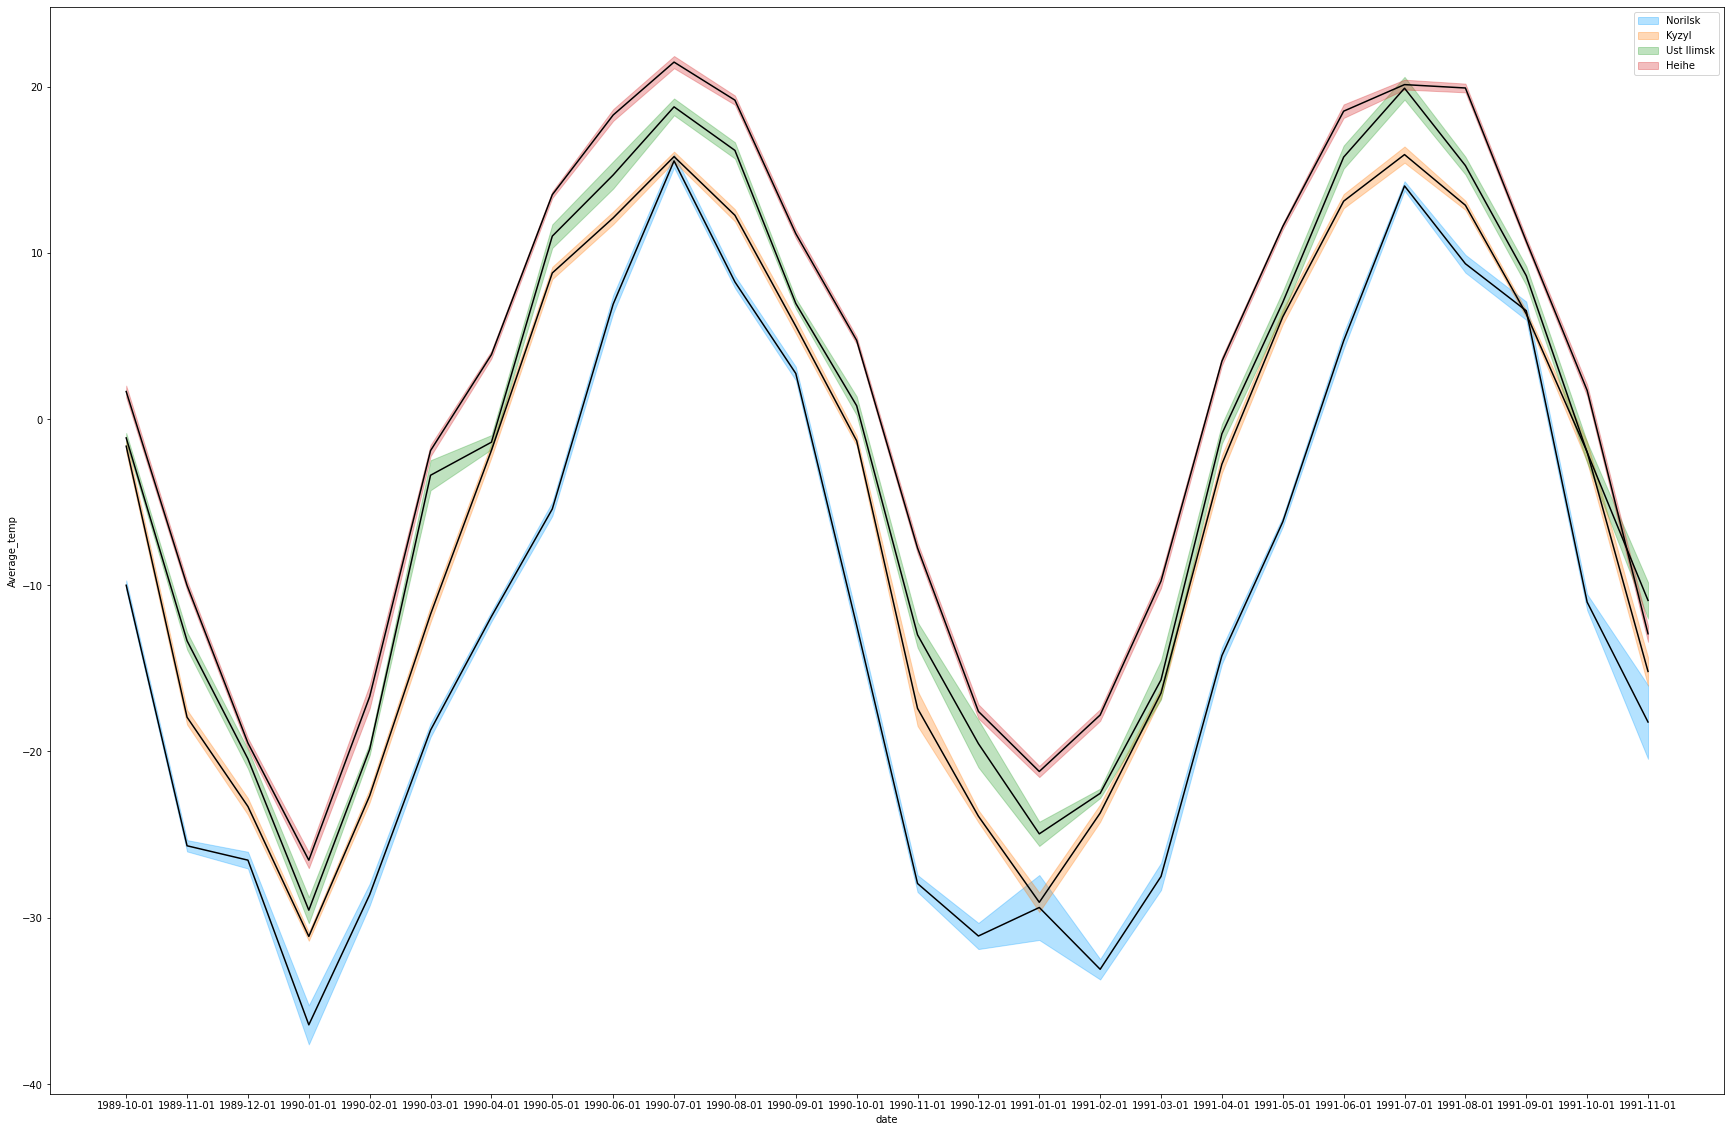

In [234]:
plt.figure(figsize=(30,20))
colors = ['#089FFf', '#ff7f0e', '#2ca02c', '#d62728']
cnt=0

for city in cities:
    df = filtered_df[filtered_df["City"]== city]
    x = df['dt']
    y = df['AverageTemperature']
    e = df['AverageTemperatureUncertainty']
    
    plt.plot(x, y, 'k-')
    plt.fill_between(x, y-e, y+e,label=city,color=colors[cnt],alpha=0.3)
    plt.legend()
    cnt+=1
    
# plt.show()
plt.xlabel("date")
plt.ylabel("Average_temp")
plt.savefig("temp_dev.png")

# Predictive Modeling

<li> Filter the dataset only containing these cities 
<li> Replace NaN values with closest values

In [236]:
df = city_df[city_df['City'].isin(cities)]
df = df.interpolate()

In [237]:
df.groupby("City").size()

City
Heihe         2318
Kyzyl         2318
Norilsk       2318
Ust Ilimsk    2318
dtype: int64

In [183]:
def split_sequence(sequence, n_steps):
    """
    Function source:
    https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
    """ 

    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [238]:
def normalize (lst):
    """
    Used to normalize a given array, such that it will have mean 0 and std 1
    """
    lst = np.asarray(lst)
    normalized = (lst - lst.mean()) / lst.std()
    return normalized

The below given cell performs these functionalities:
<li> Splits the dataset into train:val:test sets with ratio 70:20:10
<li> It makes sure that an equal portion of data from each city ends up in the train,val and test set
<li> Each time-sequence of each city is divided into multiple subsequences, composed of two parts:
    <ol> 
        <li>input: 20 datapoints
        <li>output: single value

In [239]:
time_steps=20

train_X = []
val_X = []
test_X = []

train_y = []
val_y=[]
test_y=[]


for city in cities:
    c_df = df[df["City"]== city]
    normalized = normalize(list(c_df["AverageTemperature"]))
    _x,_y = split_sequence(normalized,time_steps)
    
    n = len(_x)
    train_X.append(_x[0:int(n*0.7)])
    val_X.append(_x[int(n*0.7):int(n*0.9)])
    test_X.append(_x[int(n*0.9):])
    
    train_y.append(_y[0:int(n*0.7)])
    val_y.append(_y[int(n*0.7):int(n*0.9)])
    test_y.append(_y[int(n*0.9):])
        
train_X = np.concatenate(train_X, axis=0)
val_X = np.concatenate(val_X, axis=0)
test_X = np.concatenate(test_X, axis=0)

train_y = np.concatenate(train_y, axis=0)
val_y = np.concatenate(val_y, axis=0)
test_y = np.concatenate(test_y, axis=0)

Reshapes each input data by adding one extra dimension

In [240]:
n_features = 1
train_X= train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
val_X= val_X.reshape((val_X.shape[0], val_X.shape[1], n_features))
test_X= test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

print(train_X.shape)

(6432, 20, 1)


In [241]:
def return_model():
    """
    This function returns a LSTM model
    """
    inputShape=(time_steps, n_features)
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=inputShape))
#     model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer='Adam', loss='MSE')
    return model

In [251]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

model = return_model()
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [252]:
class_history = model.fit(train_X, train_y, epochs=200,batch_size=256, verbose=1, validation_data=(val_X,val_y))

Train on 6432 samples, validate on 1840 samples
Epoch 1/200
6432/6432 [==============================] - 2s 244us/sample - loss: 0.9060 - val_loss: 0.6743
Epoch 2/200
6432/6432 [==============================] - 0s 68us/sample - loss: 0.2134 - val_loss: 0.0909
Epoch 3/200
6432/6432 [==============================] - 0s 67us/sample - loss: 0.0496 - val_loss: 0.0741
Epoch 4/200
6432/6432 [==============================] - 0s 71us/sample - loss: 0.0436 - val_loss: 0.0634
Epoch 5/200
6432/6432 [==============================] - 0s 70us/sample - loss: 0.0412 - val_loss: 0.0620
Epoch 6/200
6432/6432 [==============================] - 0s 68us/sample - loss: 0.0389 - val_loss: 0.0588
Epoch 7/200
6432/6432 [==============================] - 0s 72us/sample - loss: 0.0379 - val_loss: 0.0584
Epoch 8/200
6432/6432 [==============================] - 0s 72us/sample - loss: 0.0367 - val_loss: 0.0543
Epoch 9/200
6432/6432 [==============================] - 0s 64us/sample - loss: 0.0367 - val_loss: 0.05

6432/6432 [==============================] - 0s 65us/sample - loss: 0.0243 - val_loss: 0.0388
Epoch 78/200
6432/6432 [==============================] - 0s 65us/sample - loss: 0.0239 - val_loss: 0.0378
Epoch 79/200
6432/6432 [==============================] - 0s 64us/sample - loss: 0.0239 - val_loss: 0.0378
Epoch 80/200
6432/6432 [==============================] - 0s 65us/sample - loss: 0.0239 - val_loss: 0.0391
Epoch 81/200
6432/6432 [==============================] - 0s 65us/sample - loss: 0.0240 - val_loss: 0.0405
Epoch 82/200
6432/6432 [==============================] - 0s 67us/sample - loss: 0.0243 - val_loss: 0.0376
Epoch 83/200
6432/6432 [==============================] - 0s 65us/sample - loss: 0.0232 - val_loss: 0.0374
Epoch 84/200
6432/6432 [==============================] - 0s 68us/sample - loss: 0.0239 - val_loss: 0.0367
Epoch 85/200
6432/6432 [==============================] - 0s 64us/sample - loss: 0.0238 - val_loss: 0.0382
Epoch 86/200
6432/6432 [==========================

6432/6432 [==============================] - 0s 67us/sample - loss: 0.0212 - val_loss: 0.0358
Epoch 154/200
6432/6432 [==============================] - 0s 64us/sample - loss: 0.0217 - val_loss: 0.0406
Epoch 155/200
6432/6432 [==============================] - 0s 68us/sample - loss: 0.0220 - val_loss: 0.0340
Epoch 156/200
6432/6432 [==============================] - 0s 65us/sample - loss: 0.0212 - val_loss: 0.0372
Epoch 157/200
6432/6432 [==============================] - 0s 65us/sample - loss: 0.0213 - val_loss: 0.0389
Epoch 158/200
6432/6432 [==============================] - 0s 66us/sample - loss: 0.0216 - val_loss: 0.0386
Epoch 159/200
6432/6432 [==============================] - 0s 64us/sample - loss: 0.0213 - val_loss: 0.0348
Epoch 160/200
6432/6432 [==============================] - 0s 66us/sample - loss: 0.0210 - val_loss: 0.0338
Epoch 161/200
6432/6432 [==============================] - 0s 62us/sample - loss: 0.0213 - val_loss: 0.0337
Epoch 162/200
6432/6432 [=================

In [253]:
model.evaluate(test_X,test_y)
y_predicted = model.predict(test_X)
y_predicted = y_predicted.reshape(test_y.shape[0])

920/920 [==============================] - 0s 145us/sample - loss: 0.0351


### Predicted and Ground-truth

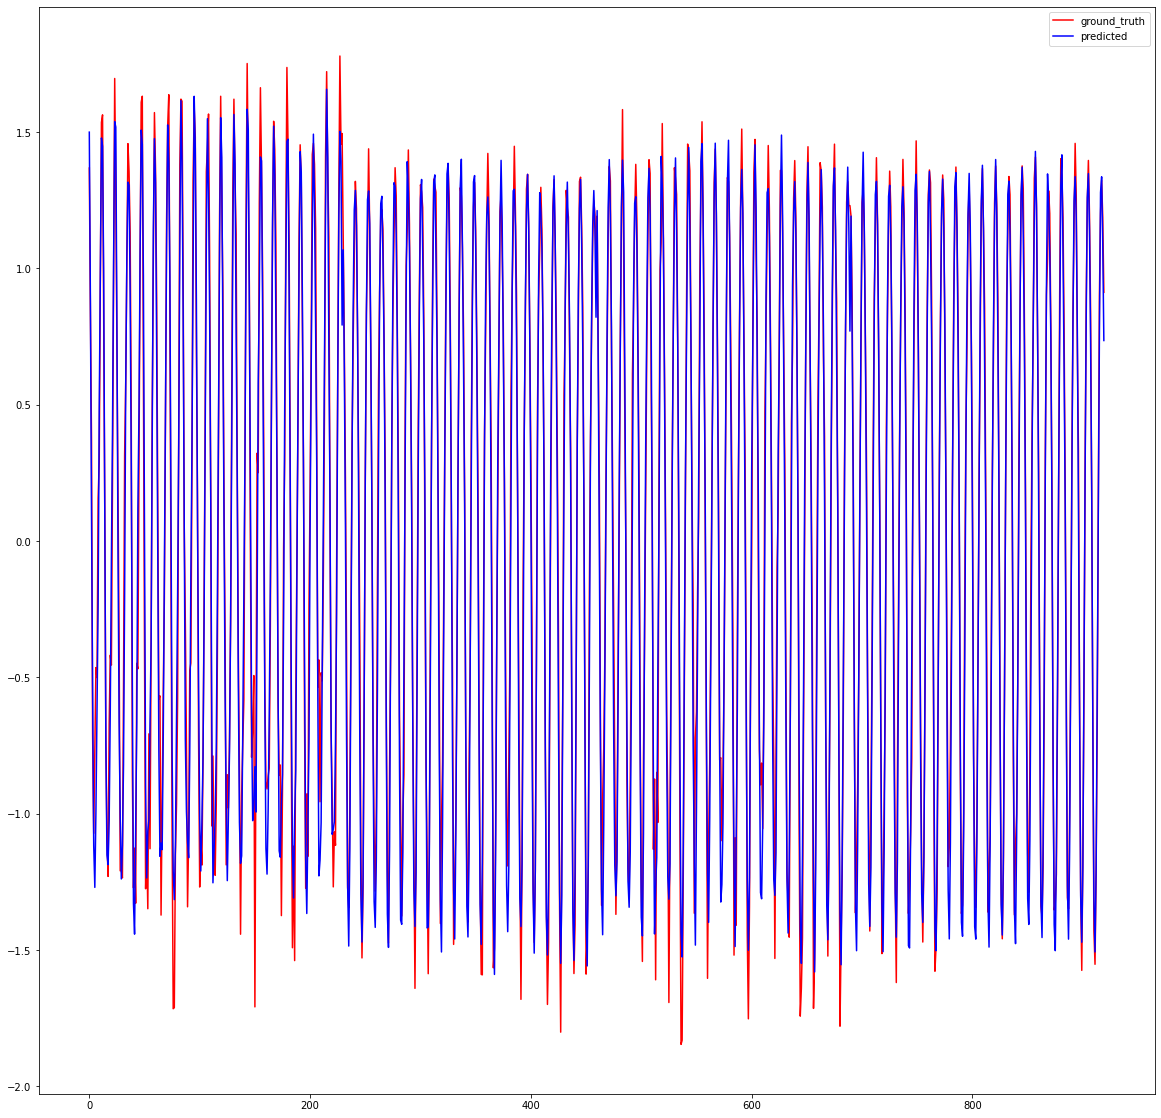

In [255]:
x = range(len(test_y))
plt.figure(figsize=(20,20))
plt.plot(x,test_y,'r',label="ground_truth")
plt.plot(x,y_predicted,'b',label="predicted")
plt.legend()

### Learning Curves

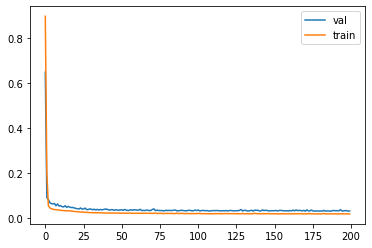

In [196]:
plt.plot(class_history.history["val_loss"],label="val")
plt.plot(class_history.history["loss"],label="train")
plt.legend()
plt.show()

a. Which preprocessing did you perform and why? <br>
The missing values of the AverageTemperature column were interpolated. If they would have been removed then the size of the training set would decrease substantially.
Another preprocessing technique is the normalization of the AverageTemperature column.

b. Are there any variables or additional data sources you could use? <br>
Additional features that could be used are the City, which can be concatenated in the dense layer. 
Another additional feature could be the season, derived from the date given in the dataset. 

c. Which methods/tools would you look into if given more time? <br>
It would be of interest to investigate other Neural Network architectures and how the performance would change while fine-tuning some parameters.
One of the possible architectures to consider are Transformers.

d. Any results you came across worth mentioning/interpreting? <br>
It is observed that the time-series is periodic. 
The first idea was to fit a curve of the form y(x) = a*cos(x) + bx + c which captures periodicity of the signal. Since I had a bit more time I decided to go with a more sophisticated LSTM model that can capture more complex dependencies within data. 

e. How satisfied and confident are you with the resulting model? <br>
The achieved score is satisfactory, The MAE in the test set is only 0.035. 
However the interpolation of the missing data, as a preprocessing technique might have added some sort of noise. 
From the given plot it can be observed that the predictions follow the same pattern as the ground-truth. 